# Using word embedding for movies recommendation

Other implementation of word embedding neural network for movies recommendation.

Focusing here on movies **CASTING and ACTORS**

# 1) Importations and functions

In [1]:
%pylab inline
import pandas as pd
import os
import seaborn as sns
import random
from keras.layers import Input, Embedding, Dot, Reshape, Dense
from keras.models import Model, model_from_json
from keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from sklearn import preprocessing, decomposition, manifold, cluster
import pickle
from matplotlib.patches import Patch
import matplotlib as mpl
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 15

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
def dynamic_std_print(string_to_print):
    """
    Printing string on standard output and refreshing output line
    """
    sys.stdout.write('\r')
    sys.stdout.write(string_to_print)
    sys.stdout.flush()

In [6]:
def iscast(row, cast):
    iscast = False
    if cast in row.cast_list:
        iscast = True
    if iscast:
        out = 1
    else:
        out = 0
    return out

In [7]:
def generate_batch(pairs, n_positive=50, negative_ratio=1.0, classification=False):
    """
    Generate batches of samples for training
    """
    batch_size = n_positive * (1 + negative_ratio)
    batch = np.zeros((batch_size, 3))
    
    # Get pairs set
    pairs_set = set(pairs)

    # Adjust label based on task
    if classification:
        neg_label = 0
    else:
        neg_label = -1
    
    # This creates a generator
    while True:
        # randomly choose positive examples
        for idx, (movie_id, cast_id) in enumerate(random.sample(pairs, n_positive)):
            batch[idx, :] = (movie_id, cast_id, 1)

        # Increment idx by 1
        idx += 1
        
        # Add negative examples until reach batch size
        while idx < batch_size:
            
            # random selection
            random_movie = random.randrange(genres_cast_df.shape[0])
            random_cast = random.randrange(len(unique_casting))
            
            # Check to make sure this is not a positive example
            if (random_movie, random_cast) not in pairs_set:
                
                # Add to batch and increment index
                batch[idx, :] = (random_movie, random_cast, neg_label)
                idx += 1
                
        # Make sure to shuffle order
        np.random.shuffle(batch)
        yield {'movie': batch[:, 0], 'cast': batch[:, 1]}, batch[:, 2]

In [8]:
def movies_embedding_model(movies_shape, cast_shape, embedding_size=50, classification=False):
    """
    Model to embed books and wikilinks using the functional API.
    Trained to discern if a movie is of a particular genre
    """
    
    # Both inputs are 1-dimensional
    movie = Input(name = 'movie', shape = [1])
    cast = Input(name = 'cast', shape = [1])
    
    # Embedding the movies (shape will be (None, 1, 50))
    movie_embedding = Embedding(name = 'movie_embedding',
                                 input_dim = movies_shape,
                                 output_dim = embedding_size)(movie)
    
    
    # Embedding the casting (shape will be (None, 1, 50))
    cast_embedding = Embedding(name = 'cast_embedding',
                            input_dim = cast_shape,
                            output_dim = embedding_size)(cast)
    
    # Merge the layers with a dot product along the second axis (shape will be (None, 1, 1))
    merged = Dot(name = 'dot_product', normalize = True, axes = 2)([movie_embedding, cast_embedding])
    
    # Reshape to be a single number (shape will be (None, 1))
    merged = Reshape(target_shape = [1])(merged)
    
    # If classifcation, add extra layer and loss function is binary cross entropy
    if classification:
        merged = Dense(1, activation = 'sigmoid')(merged)
        model = Model(inputs = [movie, cast], outputs = merged)
        model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    # Otherwise loss function is mean squared error
    else:
        model = Model(inputs = [movie, cast], outputs = merged)
        model.compile(optimizer = 'Adam', loss = 'mse')
    
    return model

In [9]:
def train_embedding(pairs, shape_movies, shape_cast, n_positive=1000, emb_size=50, verb=1):
    """
    Train neural network
    """
    # Instantiate model and show parameters
    model = movies_embedding_model(shape_movies, shape_cast, emb_size)
 
    # Generate batch
    gen = generate_batch(pairs, n_positive, negative_ratio=2, classification=True)

    # Train
    h = model.fit_generator(gen, epochs=10, 
                            steps_per_epoch=len(pairs) // n_positive,
                            verbose=verb)
    return h, model

In [10]:
def extract_embedding(layer, selection_id):
    """
    Output trained weights from embedding layer and use it to get closest recommendations
    """
    # Extract embeddings
    weights = layer.get_weights()[0]
    # Normalize weights
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    # Calculate dot product between movie and all others
    dists = np.dot(weights, weights[selection_id])
    # Sort distance indexes from smallest to largest
    sorted_dists = np.argsort(dists)
    # Take the last n sorted distances
    closest = sorted_dists[-11:]
    closest = [x for x in reversed(closest)]
    return closest, weights

In [11]:
def recom_genres(ref_genres, recommendation_df):
    """
    bar plot of genre in recommendations
    """
    list_genres = ref_genres.split(',')
    genres_recom = pd.Series(",".join(recommendation_df.genres.values.tolist()).split(",")).value_counts()
    # Gather all genres (ref and recom)
    all_genres = set(list_genres + genres_recom.index.values.tolist())
    # Get other genres
    other_genres = all_genres - set(list_genres)
    # Create serie for bar plot
    genres_bar_df = pd.Series(0, index=[list_genres + list(other_genres)])
    # Fill bar plot
    for genre in genres_recom.index:
        genres_bar_df.loc[genre] = genres_recom.loc[genre]
    return genres_bar_df

In [12]:
def recom_cast(ref_cast, recommendation_df):
    """
    Histogram of casting in recommendations
    """
    list_cast = ref_cast.split(',')
    cast_recom = pd.Series(",".join(recommendation_df.casting.values.tolist()).split(",")).value_counts()
    # Gather all cast (ref and recom)
    all_cast = set(list_cast + cast_recom.index.values.tolist())
    # Get other cast
    other_cast = all_cast - set(list_cast)
    # Create serie for histogram
    cast_histo_df = pd.Series(0, index=[list_cast + list(other_cast)])
    # Fill histogram
    for cast in cast_recom.index:
        cast_histo_df.loc[cast] = cast_recom.loc[cast]
    return cast_histo_df

In [13]:
# get a color map
my_cmap = cm.get_cmap('jet')
# get normalize function (takes data in range [vmin, vmax] -> [0, 1])
my_norm = Normalize(vmin=0, vmax=12)
# some boring fake data
myblue = 3
myorange = 9
# get a color map with two different colors
cmap_2c = cm.get_cmap('bwr')
# get normalize function (takes data in range [vmin, vmax] -> [0, 1])
norm_2c = Normalize(vmin=0, vmax=1)

In [14]:
def find_movie(string, movies_df):
    """
    Snippet of code to find movie based on its title. Find movie based on its title
    """
    return movies_df[movies_df['title'].str.lower().str.contains(string)]

# 2) Data loading

In [18]:
# Getting current path
path = os.getcwd()
file = '/data/movie_metadata_large.csv'

# Verifying data presence
try :
    data_raw = pd.read_csv(path + file, sep=',')
except FileNotFoundError :
    print("Please check if the file %s is in the 'data' folder at the current location" % file)

# 3) Data first observation

In [19]:
data_raw.shape

(53705, 4)

Not to big of a dataset, what's in it ?

In [20]:
data_raw.head()

,title,cast,genres,keywords
0,Batman & Robin,"George Clooney,Chris O'Donnell,Arnold Schwarze...","Science Fiction,Action,Fantasy,Comedy","double life,dc comics,dual identity,crime figh..."
1,About the Looking for and the Finding of Love,"Moritz Bleibtreu,Alexandra Maria Lara,Uwe Ochs...","Comedy,Drama","berlin germany,suicide,lovesickness,greece,com..."
2,The Life Aquatic with Steve Zissou,"Bill Murray,Anjelica Huston,Cate Blanchett,Wil...","Adventure,Comedy,Drama","parent child relationship,red cap,rivalry,dysf..."
3,8½,"Marcello Mastroianni,Claudia Cardinale,Anouk A...","Fantasy,Drama","individual,scapegoat,adultery,screenplay,cinec..."
4,The Pianist,"Adrien Brody,Thomas Kretschmann,Frank Finlay,M...","Drama,War","resistance,holocaust,hunger,world war ii,priso..."


Modify column's name

In [21]:
data_raw.columns = ['title', 'casting', 'genres', 'keywords']

Obvious duplicates ?

In [22]:
data_raw[data_raw.duplicated()].shape

(12, 4)

Drop obvious duplicates if any

In [23]:
data_raw = data_raw.drop_duplicates(keep='first')
data_raw.shape

(53693, 4)

Movies duplicates ?

In [24]:
dup = data_raw[data_raw.duplicated(subset=["title"])]
n_dup = dup.shape[0]
print("%i duplicates sharing movie title" % n_dup)
print(dup.title.head(10))

2825 duplicates sharing movie title
49                       Shaft
303                    The Fog
311          Annaluise & Anton
318                   The Omen
383         Planet of the Apes
424    The Thomas Crown Affair
434           Dawn of the Dead
524         The Miracle Worker
640    Blood: The Last Vampire
753                      Crash
Name: title, dtype: object


Duplicates are most likely remakes

In [25]:
data_raw[data_raw.title == "The Thomas Crown Affair"]

,title,casting,genres,keywords
423,The Thomas Crown Affair,"Steve McQueen,Faye Dunaway,Paul Burke,Jack Wes...","Romance,Crime,Thriller,Drama","in love with enemy,hold-up robbery,boredom,ins..."
424,The Thomas Crown Affair,"Pierce Brosnan,Rene Russo,Denis Leary,Ben Gazz...","Drama,Crime,Romance","martinique,claude monet,famous painting,glider..."


# 4) Missing values

In [26]:
data_raw.isna().sum()

title           0
casting      5271
genres       5496
keywords    21723
dtype: int64

Remove rows with missing values

In [27]:
data_raw = data_raw.dropna(subset=['casting'])
data_raw.shape

(48422, 4)

In [28]:
data_raw.isna().sum()

title           0
casting         0
genres       3316
keywords    17626
dtype: int64

# 5) Feature Engineering

In [29]:
data_raw.head(1)

,title,casting,genres,keywords
0,Batman & Robin,"George Clooney,Chris O'Donnell,Arnold Schwarze...","Science Fiction,Action,Fantasy,Comedy","double life,dc comics,dual identity,crime figh..."


Pass genres andcasting to lowercase

In [30]:
data_raw.loc[:, 'casting'] = data_raw.casting.apply(lambda x: x.lower())

In [31]:
data_raw.head(1)

,title,casting,genres,keywords
0,Batman & Robin,"george clooney,chris o'donnell,arnold schwarze...","Science Fiction,Action,Fantasy,Comedy","double life,dc comics,dual identity,crime figh..."


In [32]:
# Filter out stop words
stop_words = set(stopwords.words('english'))

In [33]:
# Get splitted casting in a serie
s = data_raw.casting.str.lower().str.split(",").values.tolist()
# Get unique casting
casting = [casting_out for casting_in in s for casting_out in casting_in]
# Remove stopwords
stop_words = set(stopwords.words('english'))
casting_tokens_sw = [w for w in casting if not w in stop_words]
set_casting = set(casting_tokens_sw)
unique_casting = list(set_casting)
print("%i actors in the dataset" % len(unique_casting))
cast_index = {cast: idx for idx, cast in enumerate(unique_casting)}

216974 actors in the dataset


Create new dataframe

In [34]:
genres_cast_df = data_raw.loc[:, ['title', 'genres', 'casting']]
genres_cast_df = genres_cast_df.reset_index(drop=True)
genres_cast_df.head(1)

,title,genres,casting
0,Batman & Robin,"Science Fiction,Action,Fantasy,Comedy","george clooney,chris o'donnell,arnold schwarze..."


In [35]:
# Take strings and output list of tokens in lower case
genres_cast_df.loc[:, 'cast_list'] = genres_cast_df.casting.apply(lambda x: x.lower().split(","))

# 6) Supervised learning issue : is an actor in a specific movie's casting ?

In [37]:
genres_cast_df.head(1)

,title,genres,casting,cast_list
0,Batman & Robin,"Science Fiction,Action,Fantasy,Comedy","george clooney,chris o'donnell,arnold schwarze...","[george clooney, chris o'donnell, arnold schwa..."


### Building pairs for supervised training : is a specific actor in the movies casting ?

In [38]:
try:
    pairs = pickle.load(open(path + '/data/pairs_casting.pkl', 'rb'))
except FileNotFoundError:
    pairs = []
    # Iterate through each movie
    for i in range(0, genres_cast_df.shape[0]):
        dynamic_std_print('Movie %i / %i' % (i, genres_cast_df.shape[0]))
        # Iterate through the casting of the movies
        pairs.extend((i, cast_index[cast]) for cast in genres_cast_df.iloc[i,:].cast_list if cast in unique_casting)
    pickle.dump(pairs, open(path + '/data/pairs_casting.pkl', 'wb'))

In [39]:
print('We have less than %i positives examples' % (ceil(len(pairs) / 10000) * 10000))

We have less than 620000 positives examples


Test batch-generating function

In [40]:
next(generate_batch(pairs, n_positive=2, negative_ratio=2))

({'movie': array([28703., 13505.,   735.,  4957., 46403.,  9804.]),
  'cast': array([195424., 190423.,  76254.,  94663.,  66520.,   8530.])},
 array([-1., -1., -1.,  1., -1.,  1.]))

Save input dataframe for easy loading and usage in hard code

In [109]:
# pickle.dump(genres_cast_df, open('data/recom_casting_df.pkl', 'wb'))

# 7) Neural Network Model

Implement the neural network with two embedding layers :
- one for the movies titles
- one for the casting

In [43]:
n_positive = 1000
try:
    # load json and create model
    json_file = open(path + '/data/model_casting.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    emb_model = model_from_json(loaded_model_json)
    # load weights into new model
    emb_model.load_weights(path + "/data/model_casting.h5")
    print("Loaded model from disk")
except FileNotFoundError:
    history, emb_model = train_embedding(pairs, genres_cast_df.shape[0], len(unique_casting), n_positive, emb_size=100)
    # serialize model to JSON
    model_json = emb_model.to_json()
    with open(path + "/data/model_casting.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    emb_model.save_weights(path + "/data/model_casting.h5")
    print("Saved model to disk")

Loaded model from disk


As we see the model's loss to decrease as the epochs run, we may have hope that the model is learning somethin.

Let's point out that the supervised learning is what we are looking for here, not the classification outcome. The learning itself allows the model to actually learn and modify the embeddings layers weights, which are the coordinates of our words (titles or casting) in their own vectorial 50 (or 100) - dimensional space.

In [44]:
# Select any movie for testing
movie_id = 0

In [45]:
# Get layer
layer = emb_model.get_layer('movie_embedding')
# Extract weights
recommendation, movies_weights = extract_embedding(layer, movie_id)
# Get recommendations (closest movies)
recom_df = genres_cast_df.loc[recommendation[1:], ['title', 'genres', 'casting']]
# Display reference
display(genres_cast_df.loc[movie_id, ['title', 'genres', 'casting']].to_frame())
# Display recommendation
display(recom_df)
# Get recommendations genres
genres_reco = pd.Series(",".join(recom_df.genres.values.tolist()).split(","))
# Count cast of selected movie
n_cast = len(genres_cast_df.loc[movie_id, :].cast_list)
# Process recommendation casting
casting_recommendation = recom_cast(genres_cast_df.loc[movie_id, :].casting, recom_df)
# Compute cast accuracy for recommendations
cast_accuracy = casting_recommendation.iloc[:n_cast].sum() / casting_recommendation.sum()
print('casting accuracy : {:.2f}'.format(cast_accuracy))

,0
title,Batman & Robin
genres,"Science Fiction,Action,Fantasy,Comedy"
casting,"george clooney,chris o'donnell,arnold schwarze..."


,title,genres,casting
378,Planet of the Apes,"Thriller,Science Fiction,Action,Adventure","mark wahlberg,tim roth,helena bonham carter,mi..."
5155,The Player,"Comedy,Drama,Crime","tim robbins,greta scacchi,fred ward,whoopi gol..."
256,Top Gun,"Action,Romance","tom cruise,kelly mcgillis,val kilmer,anthony e..."
6677,Speed Zone,"Action,Comedy","john candy,donna dixon,matt frewer,joe flahert..."
11108,Shadows and Fog,"Thriller,Comedy","woody allen,kathy bates,john cusack,mia farrow..."
3932,Wayne's World 2,"Music,Comedy","mike myers,dana carvey,christopher walken,tia ..."
8320,School Ties,Drama,"brendan fraser,matt damon,chris o'donnell,rand..."
5461,Bobby,"History,Drama","anthony hopkins,heather graham,ashton kutcher,..."
1431,Deconstructing Harry,"Comedy,Drama","woody allen,kirstie alley,billy crystal,judy d..."
44576,Johnny Skidmarks,"Thriller,Crime,Drama,Mystery","peter gallagher,frances mcdormand,john lithgow..."


casting accuracy : 0.01


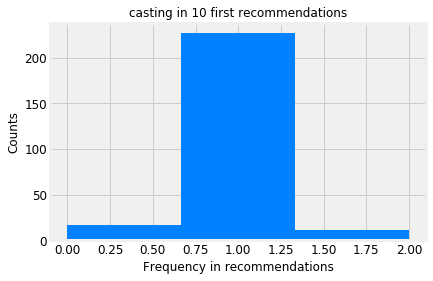

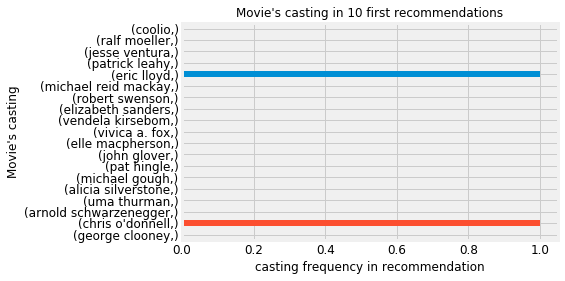

In [46]:
# Process recomendation casting
casting_recommendation = recom_cast(genres_cast_df.loc[movie_id, :].casting, recom_df)
# Define vector for colors
my_data = [myblue]*n_cast + (casting_recommendation.shape[0] - n_cast)*[myorange]

# Plot
# First plot : movie's casting histogram
fig, ax = plt.subplots()
ax = casting_recommendation.plot.hist(color=my_cmap(my_norm(my_data)), fontsize=12, bins=len(casting_recommendation.unique()))
# Set axis labels and title
ax.set_xlabel("Frequency in recommendations", fontsize=12)
ax.set_ylabel("Counts", fontsize=12)
ax.set_title("casting in 10 first recommendations", fontsize=12)
# pyplot.locator_params(axis='x', nbins=3)

# Second plot : movie's casting frequency
fig, ax = plt.subplots()
# Movie's casting for barplot
movie_cast = casting_recommendation.loc[genres_cast_df.loc[movie_id, :].cast_list]
ax = movie_cast.plot.barh(fontsize=12)
# Set axis labels and title
ax.set_xlabel("casting frequency in recommendation", fontsize=12)
ax.set_ylabel("Movie's casting", fontsize=12)
ax.set_title("Movie's casting in 10 first recommendations", fontsize=12);

2 actors have been found in recommendations which is low but understandable given the amount of actors

# 8) Visualisations

We will try to look at the embedding space of our movies titles, in order to make (hopefully) gatherings. For this task we will use TSNE manifold algorithm, projected on the 2 principal components of our embedded space in order to be able to visualize the space.

TSNE

In [47]:
tsne_test = manifold.TSNE(n_components=2, perplexity=100, n_iter=1000, metric='cosine').fit_transform(movies_weights)

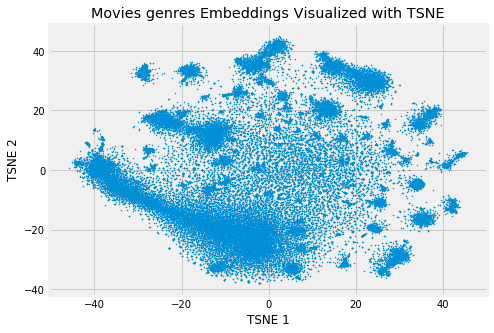

In [48]:
plt.figure(figsize = (7, 5))
plt.scatter(tsne_test[:, 0], tsne_test[:, 1], s=1)
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Movies genres Embeddings Visualized with TSNE');

At first glence once can see many clusters, but let's be careful before jumping to conclusions with TSNE outputs which are known to be as magical as difficult to master.

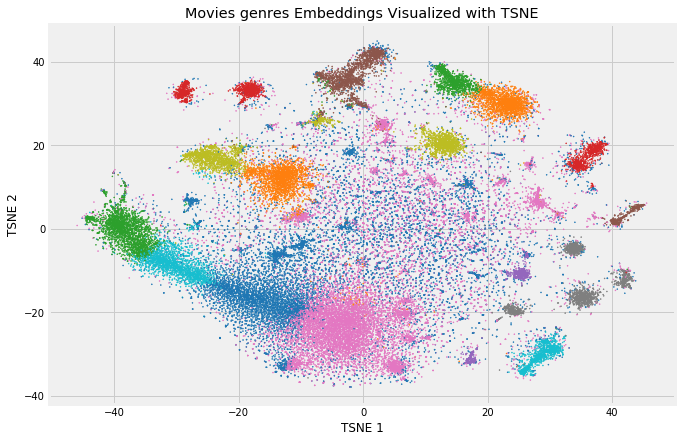

In [50]:
kmeans = cluster.KMeans(n_clusters=20)
kmeans = kmeans.fit(movies_weights)
categs_kmeans = kmeans.predict(movies_weights)
plt.figure(figsize = (10, 7))
plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c=categs_kmeans, s=1,cmap=plt.cm.tab10)
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Movies genres Embeddings Visualized with TSNE');

Trying to identify what is the SOUTH cluster

In [51]:
ids_south_cluster = np.where((tsne_test[:, 0] < -0) & (tsne_test[:, 0] > -10) & (tsne_test[:, 1] < -20))[0]
genres_cast_df.loc[ids_south_cluster, ['title', 'genres', 'casting']]

,title,genres,casting
6,Ice Age,"Animation,Comedy,Family,Adventure","ray romano,john leguizamo,denis leary,goran vi..."
25,Leaving Las Vegas,"Drama,Romance","nicolas cage,elisabeth shue,julian sands,richa..."
28,Romeo + Juliet,"Drama,Romance","leonardo dicaprio,claire danes,john leguizamo,..."
34,Erin Brockovich,Drama,"julia roberts,albert finney,aaron eckhart,marg..."
46,Shaft,"Action,Adventure,Crime,Thriller","samuel l. jackson,jeffrey wright,christian bal..."
55,Being John Malkovich,"Comedy,Drama,Fantasy","john cusack,cameron diaz,catherine keener,john..."
59,The Green Mile,"Fantasy,Drama,Crime","tom hanks,michael clarke duncan,david morse,bo..."
86,Terminator Salvation,"Action,Science Fiction,Thriller","christian bale,sam worthington,anton yelchin,m..."
90,D.E.B.S.,Action,"sara foster,meagan good,jordana brewster,devon..."
94,There's Something About Mary,"Romance,Comedy","ben stiller,cameron diaz,matt dillon,lee evans..."


AMERICANS ACTORS !

Trying to identify what is the EAST cluster

In [52]:
ids_east_cluster = np.where((tsne_test[:, 0] > 40) & (tsne_test[:, 1] > 0) & (tsne_test[:, 1] < 10))[0]
genres_cast_df.loc[ids_east_cluster, ['title', 'genres', 'casting']]

,title,genres,casting
26,The Idiots,"Drama,Comedy","bodil jrgensen,jens albinus,anne louise hassin..."
493,Adam's Apples,"Drama,Comedy,Crime","mads mikkelsen,ulrich thomsen,paprika steen,ol..."
877,We Shall Overcome,Drama,"bent mejding,anders w. berthelsen,jens jrn spo..."
1073,Pusher,"Action,Crime,Drama,Thriller","kim bodnia,mads mikkelsen,laura drasbk,zlatko ..."
1885,After the Wedding,Drama,"mads mikkelsen,stine fischer christensen,sidse..."
1978,Brothers,"Drama,War","connie nielsen,ulrich thomsen,nikolaj lie kaas..."
2512,The Green Butchers,Comedy,"nikolaj lie kaas,mads mikkelsen,line kruse,nic..."
2530,The Good Cop,"Action,Comedy","kim bodnia,rene dif,nicolas bro,robert hansen,..."
2621,Dark Horse,"Comedy,Drama","jakob cedergren,nicolas bro,tilly scott peders..."
2636,The Boss of It All,Comedy,"jens albinus,peter gantzler,benedikt erlingsso..."


DANISH ACTORS !

Trying to identify what is the NORTH cluster

In [53]:
ids_north_cluster = np.where((tsne_test[:, 0] < 10) & (tsne_test[:, 0] > -10) & (tsne_test[:, 1] > 30))[0]
genres_cast_df.loc[ids_north_cluster, ['title', 'genres', 'casting']]

,title,genres,casting
3,8½,"Fantasy,Drama","marcello mastroianni,claudia cardinale,anouk a..."
10,"The Good, the Bad and the Ugly",Western,"clint eastwood,eli wallach,lee van cleef,aldo ..."
19,La Dolce Vita,"Comedy,Drama","marcello mastroianni,anita ekberg,anouk aimee,..."
57,Shaft in Africa,"Adventure,Action,Thriller,Crime,Mystery","richard roundtree,frank finlay,vonetta mcgee,n..."
101,Bread and Tulips,"Drama,Comedy,Romance","licia maglietta,bruno ganz,giuseppe battiston,..."
158,The Passion of the Christ,Drama,"jim caviezel,maia morgenstern,monica bellucci,..."
180,Life Is Beautiful,"Comedy,Drama","roberto benigni,nicoletta braschi,giorgio cant..."
313,Roman Holiday,"Comedy,Romance,Drama","gregory peck,audrey hepburn,eddie albert,hartl..."
342,Umberto D.,Drama,"carlo battisti,lina gennari,ileana simova,elen..."
438,Don't Look Now,"Thriller,Drama,Horror","julie christie,donald sutherland,hilary mason,..."


ITALIANS ACTORS !

Trying to identify what is the large MIDDLE cluster

In [54]:
ids_middle_cluster = np.where((tsne_test[:, 0] < -10) & (tsne_test[:, 0] > -20) & (tsne_test[:, 1] > 5) & (tsne_test[:, 1] < 15))[0]
genres_cast_df.loc[ids_middle_cluster, ['title', 'genres', 'casting']]

,title,genres,casting
38,The Hole,"Crime,Drama,Horror,Thriller","thora birch,desmond harrington,keira knightley..."
42,Bandyta,Drama,"til schweiger,polly walker,ida jablonska,barte..."
69,Love Actually,"Comedy,Romance,Drama","hugh grant,liam neeson,colin firth,laura linne..."
70,Notting Hill,"Romance,Comedy,Drama","julia roberts,hugh grant,gina mckee,tim mcinne..."
73,Scoop,"Comedy,Mystery","scarlett johansson,hugh jackman,woody allen,ia..."
84,A Close Shave,"Family,Animation,Comedy","peter sallis,anne reid"
112,The Mummy,"Adventure,Action,Fantasy","brendan fraser,rachel weisz,john hannah,oded f..."
129,Life of Brian,Comedy,"graham chapman,john cleese,terry gilliam,eric ..."
135,The Hours,Drama,"nicole kidman,julianne moore,meryl streep,step..."
136,The Da Vinci Code,"Thriller,Mystery","tom hanks,audrey tautou,ian mckellen,paul bett..."


AMERICANS ?

Movies with actor ?

In [55]:
def find_actor(name, df, plot):  
    # Build a test vector for the 'name' actor
    test_name = df.apply(iscast, args=(name,), axis=1)
    sizes_name = test_name.apply(lambda x: 0.1 if x == 0 else 100)
    # Plot
    plt.figure(figsize = (12, 12))
    plt.scatter(plot[:, 0], plot[:, 1], c=cmap_2c(norm_2c(test_name.values)), s=sizes_name)
    plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Movies genres Embeddings Visualized with TSNE');

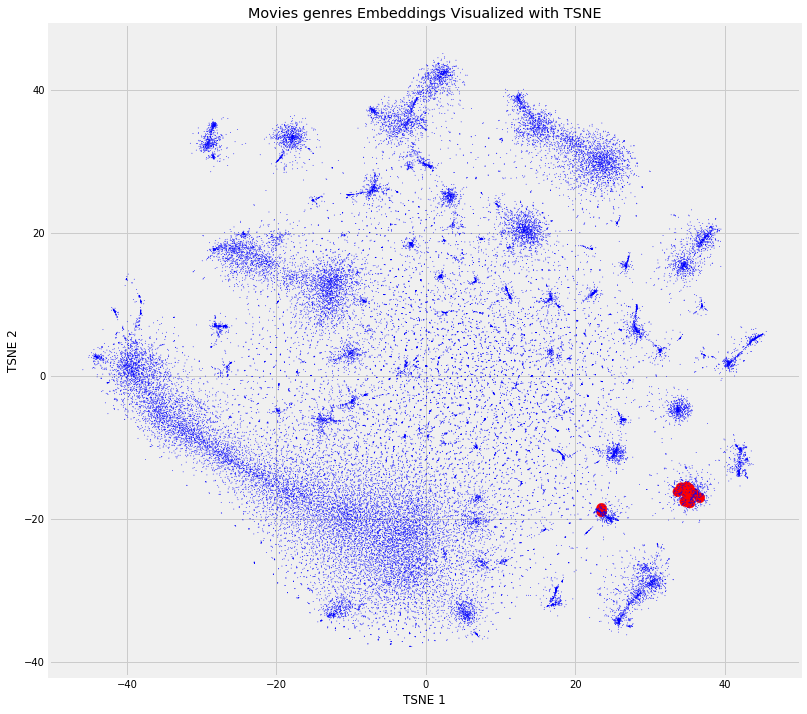

In [56]:
find_actor('shun oguri', genres_cast_df, tsne_test)

A bit of tuning for the casting lists

In [57]:
# Remove missing value from actors list
genres_cast_df.loc[:, 'cast_list'] = genres_cast_df.cast_list.apply(lambda x: [actor for actor in x if actor != ' '] if ' ' in x else x)
genres_cast_df.loc[:, 'cast_list'] = genres_cast_df.cast_list.apply(lambda x: [actor for actor in x if actor != ' jr'] if ' jr' in x else x)
genres_cast_df.loc[:, 'cast_list'] = genres_cast_df.cast_list.apply(lambda x: [actor for actor in x if actor != ' jr.'] if ' jr.' in x else x)

In [58]:
# for i in range(genres_cast_df.shape[0]):
#     if ' jr.' in genres_cast_df.iloc[i, :].cast_list:
#         print(genres_cast_df.iloc[i, :].title)

In [59]:
# genres_cast_df.casting[genres_cast_df.title == 'Easy Rider'].values

In [60]:
# genres_cast_df.cast_list[genres_cast_df.title == 'Easy Rider'].values[0]

Building casting counts : most popular actors within the database

In [61]:
# Gather all casting from all movies
movies_casting = genres_cast_df.cast_list.values.tolist()
movies_casting_list = [inner for outer in movies_casting for inner in outer]
# Count occurences
val, counts = np.unique(np.array(movies_casting_list), return_counts=True)
# Create array for best import to dataframe
count_array = np.hstack([val.reshape(-1,1), counts.reshape(-1,1)])
# Create dataframe
cast_count_df = pd.DataFrame(count_array, columns=['cast', 'count'])
cast_count_df.loc[:, 'count'] = cast_count_df.loc[:, 'count'].astype(int)
cast_count_df = cast_count_df.sort_values('count', ascending=False)
cast_count_df = cast_count_df.reset_index(drop=True)
cast_count_df.head(20)

,cast,count
0,bess flowers,229
1,clarence nash,189
2,frank welker,165
3,christopher lee,141
4,gerard depardieu,124
5,debbie rochon,116
6,john carradine,115
7,buster keaton,114
8,john wayne,109
9,jackie chan,106


In [62]:
cast_count_df[cast_count_df.loc[:, 'count'] > 1].shape

(81575, 2)

A few casting are frequent, most are rare

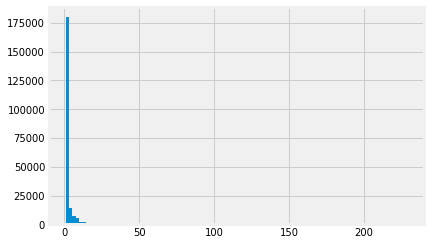

In [63]:
cast_count_df.loc[:, 'count'].hist(bins=100);

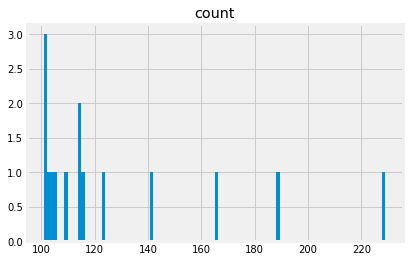

In [64]:
cast_count_df[cast_count_df.loc[:, 'count'] > 100].hist(bins=100);

# Rough Gathering of  Nationalities from wikipedia

In [65]:
def change_value_by_nationality(string, countries_list):
    new_country = string
    if string not in countries_list:
        for country in countries_list:
            if string.startswith(country):
                new_country = country
        return new_country
    else:
        return string
    
def load_countries(file_name):
    path = os.getcwd()
    countries_df = pickle.load(open(path + file_name, 'rb'))
    # Cleaning values retrieved
    print("Replacing countries starting with lovercase by ERROR")
    countries_df.country = countries_df.country.apply(lambda x: 'ERROR' if (len(x) > 0) and (x[0].islower()) else x)
    print("Replacing countries with less than 4 letters by ERROR")
    countries_df.country = countries_df.country.apply(lambda x: 'ERROR' if len(x) < 4 else x)
    print("Replacing '-born' with ''")
    countries_df.country = countries_df.country.apply(lambda x: x.replace('-born', ''))
    print("Replacing '\\n' with ' '")
    countries_df.country = countries_df.country.apply(lambda x: x.replace('\n', ' '))
    print("Replacing '/' with ' '")
    countries_df.country = countries_df.country.apply(lambda x: x.replace('/', ' '))
    print("Replacing '\' with ' '")
    countries_df.country = countries_df.country.apply(lambda x: x.replace('\\', ' '))
    print("Replacing '_' with ' '")
    countries_df.country = countries_df.country.apply(lambda x: x.replace('_', ' '))
    print("Replacing '[' with ' '")
    countries_df.country = countries_df.country.apply(lambda x: x.replace('[', ' '))
    print('Stripping spaces and commas')
    countries_df.country = countries_df.country.apply(lambda x: x.strip())
    countries_df.country = countries_df.country.apply(lambda x: x.strip(','))
    print("Nationalities found :", countries_df.country.value_counts().shape[0])
    print("Spliting along '-'")
    countries_df.country = countries_df.country.apply(lambda x: x.split('-')[0])
    print("Nationalities found :", countries_df.country.value_counts().shape[0])
    print("Spliting along ' '")
    countries_df.country = countries_df.country.apply(lambda x: x.split(' ')[0])
    print("Nationalities found :", countries_df.country.value_counts().shape[0])
    print("Replacing 'United' by 'American'")
    countries_df.country = countries_df.country.apply(lambda x: 'American' if x == 'United' else x)
    print("Nationalities found :", countries_df.country.value_counts().shape[0])
    print("Replacing 'Native' by 'American' event it may be 'Canadian'")
    countries_df.country = countries_df.country.apply(lambda x: 'American' if x == 'Native' else x)
    print("Nationalities found :", countries_df.country.value_counts().shape[0])
    print("Replacing 'Anglo' by 'English' event it is not always the most accurate")
    countries_df.country = countries_df.country.apply(lambda x: 'English' if x == 'Anglo' else x)
    print("Nationalities found :", countries_df.country.value_counts().shape[0])
    print("Replacing 'Canada' by 'Canadian'")
    countries_df.country = countries_df.country.apply(lambda x: 'Canadian' if x == 'Canada' else x)
    print("Nationalities found :", countries_df.country.value_counts().shape[0])
    print("Replacing 'India' by 'Indian'")
    countries_df.country = countries_df.country.apply(lambda x: 'Indian' if x == 'India' else x)
    print("Nationalities found :", countries_df.country.value_counts().shape[0])
    print("Replacing 'Argentinian' by 'Argentine'")
    countries_df.country = countries_df.country.apply(lambda x: 'Argentine' if x == 'Argentinian' else x)
    print("Nationalities found :", countries_df.country.value_counts().shape[0])
    print("Replacing 'Germany' by 'German'")
    countries_df.country = countries_df.country.apply(lambda x: 'German' if x == 'Germany' else x)
    print("Nationalities found :", countries_df.country.value_counts().shape[0])
    
    return countries_df

In [67]:
# Get and clean countries
cast_count_df_test = load_countries('/data/casting_count_df.pkl')
# Removing remaining double nationalities
todelete_countries = ['', 'ERROR', 'Stand', 'U.S.']
# Observing values retrieved
countries_count = cast_count_df_test.country.value_counts()
cast_count_df_test.country = cast_count_df_test.country.apply(change_value_by_nationality, args=(countries,))
# Observing values retrieved
countries_count = cast_count_df_test.country.value_counts()
countries_count

Replacing countries starting with lovercase by ERROR
Replacing countries with less than 4 letters by ERROR
Replacing '-born' with ''
Replacing '\n' with ' '
Replacing '/' with ' '
Replacing '' with ' '
Replacing '_' with ' '
Replacing '[' with ' '
Stripping spaces and commas
Nationalities found : 686
Spliting along '-'
Nationalities found : 478
Spliting along ' '
Nationalities found : 412
Replacing 'United' by 'American'
Nationalities found : 411
Replacing 'Native' by 'American' event it may be 'Canadian'
Nationalities found : 410
Replacing 'Anglo' by 'English' event it is not always the most accurate
Nationalities found : 409
Replacing 'Canada' by 'Canadian'
Nationalities found : 408
Replacing 'India' by 'Indian'
Nationalities found : 407
Replacing 'Argentinian' by 'Argentine'
Nationalities found : 406
Replacing 'Germany' by 'German'
Nationalities found : 405


ERROR              194991
American             9296
English              1730
French                958
Canadian              952
Italian               927
Japanese              913
German                832
British               824
Indian                588
Swedish               365
Australian            320
Danish                267
Spanish               243
Chinese               241
Korean                224
Russian               189
Soviet                166
Irish                 164
Austrian              162
Scottish              157
Mexican               143
Brazilian             121
Czech                 112
Polish                111
Filipino               87
Finnish                85
Hong                   83
South                  81
Norwegian              80
                    ...  
2008                    1
Cree                    1
Harvard                 1
Neuroscience            1
Logie                   1
Honorary                1
Utrecht                 1
Singapore   

In [68]:
countries = countries_count[countries_count > 10].index.values
countries = countries[~np.isin(countries, todelete_countries)]
countries

array(['American', 'English', 'French', 'Canadian', 'Italian', 'Japanese',
       'German', 'British', 'Indian', 'Swedish', 'Australian', 'Danish',
       'Spanish', 'Chinese', 'Korean', 'Russian', 'Soviet', 'Irish',
       'Austrian', 'Scottish', 'Mexican', 'Brazilian', 'Czech', 'Polish',
       'Filipino', 'Finnish', 'Hong', 'South', 'Norwegian', 'Dutch',
       'Welsh', 'Serbian', 'Belgian', 'Hungarian', 'Turkish', 'Argentine',
       'Swiss', 'Israeli', 'Romanian', 'Greek', 'Portuguese', 'Thai',
       'Cuban', 'Puerto', 'Slovak', 'Northern', 'Egyptian', 'Armenian',
       'Chilean', 'Croatian', 'Iranian', 'Taiwanese', 'Tamil', 'African',
       'Jamaican', 'Czechoslovak', 'Lithuanian', 'Trinidadian',
       'Malaysian'], dtype=object)

In [107]:
# cast_count_df_test_test = pickle.load(open(path + '/data/casting_count_df.pkl', 'rb'))
# cast_count_df_test_test[cast_count_df_test_test.country != ''].shape

(37794, 3)

In [70]:
actors_trusted_country = cast_count_df_test[cast_count_df_test.country.isin(countries)]
# Label encode trusted countries values
le_countries = preprocessing.LabelEncoder().fit(countries)
actors_trusted_country.loc[:, 'country_enc'] = actors_trusted_country.country.apply(lambda x: le_countries.transform([x])[0])

/home/noel/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/noel/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [74]:
cast_count_df_test

,cast,count,country
0,bess flowers,229,American
1,clarence nash,189,American
2,frank welker,165,American
3,christopher lee,141,British
4,gerard depardieu,124,French
5,debbie rochon,116,Canadian
6,john carradine,115,American
7,buster keaton,114,American
8,john wayne,109,American
9,jackie chan,106,Chinese


In [75]:
actors_index = dict(zip(cast_count_df_test.cast.values, cast_count_df_test.index.values))

In [76]:
cast_df = genres_cast_df.loc[:, ['title', 'cast_list']]
cast_df.loc[:, 'first_actor'] = cast_df.cast_list.apply(lambda x: x[0])
cast_df.loc[:, 'first_actor_enc'] = cast_df.first_actor.apply(lambda x: actors_index[x])
cast_df.loc[:, 'first_actor_natio'] = cast_df.first_actor_enc.apply(lambda x: cast_count_df_test.country.loc[x])

In [77]:
cast_df.head(2)

,title,cast_list,first_actor,first_actor_enc,first_actor_natio
0,Batman & Robin,"[george clooney, chris o'donnell, arnold schwa...",george clooney,788,American
1,About the Looking for and the Finding of Love,"[moritz bleibtreu, alexandra maria lara, uwe o...",moritz bleibtreu,1149,German


## Try to color the mapping with most common nationalities

In [78]:
# Create dataframe
first_natio_count_df = cast_df.loc[:, 'first_actor_natio'].value_counts()
first_natio_count_df = first_natio_count_df.loc[first_natio_count_df.index != 'ERROR']
first_natio_count_df.head(4)

American    13914
English      2251
French       1797
Italian      1159
Name: first_actor_natio, dtype: int64

Get N most common nationalities

In [79]:
N_natios = 30

In [80]:
index_most_common_nationality = {natio : idw for idw, natio in enumerate(first_natio_count_df.head(N_natios).index.values.tolist())}
index_most_common_nationality['Other'] = N_natios
index_most_common_nationality

{'American': 0,
 'English': 1,
 'French': 2,
 'Italian': 3,
 'Canadian': 4,
 'Japanese': 5,
 'German': 6,
 'Indian': 7,
 'British': 8,
 'Chinese': 9,
 'Swedish': 10,
 'Australian': 11,
 'Korean': 12,
 'Spanish': 13,
 'Danish': 14,
 'Russian': 15,
 'Irish': 16,
 'Scottish': 17,
 'Austrian': 18,
 'Dutch': 19,
 'Soviet': 20,
 'Mexican': 21,
 'Stand': 22,
 'Czech': 23,
 'South': 24,
 'Brazilian': 25,
 'Belgian': 26,
 'Norwegian': 27,
 'Welsh': 28,
 'Finnish': 29,
 'Other': 30}

In [81]:
def input_color(natio, target, value, N_natios):
    if target == natio:
        return value
    else:
        return N_natios

Assess nationalities to movie

In [82]:
movies_natio_df = cast_df.loc[:, ['title', 'first_actor_natio']]
for natio, value in index_most_common_nationality.items():
    movies_natio_df.loc[:, natio] = cast_df.first_actor_natio.apply(input_color, args=(natio, value, N_natios))
movies_natio_df.head(1)

,title,first_actor_natio,American,English,French,Italian,Canadian,Japanese,German,Indian,...,Mexican,Stand,Czech,South,Brazilian,Belgian,Norwegian,Welsh,Finnish,Other
0,Batman & Robin,American,0,30,30,30,30,30,30,30,...,30,30,30,30,30,30,30,30,30,30


Select color and size of movie

In [83]:
def select_color(row, N_natios):
    if (row == N_natios).astype(int).sum() != N_natios + 1:
        return row[row != N_natios].values[0]
    else:
        return N_natios
movies_natio_df.loc[:, 'colors'] = movies_natio_df.iloc[:, 2:].apply(select_color, args=(N_natios,), axis=1)
movies_natio_df.loc[:, 'sizes'] = movies_natio_df.colors.apply(lambda x: 1 if x == N_natios else 10)

Get median coordinates of movies of certain categories for labelling

In [84]:
movies_common_natio_sample = {}
for natio, color in index_most_common_nationality.items():
    movie_color_sample = movies_natio_df.loc[:, 'colors'][movies_natio_df.loc[:, 'colors'] == color]
    tsne_coordinates = tsne_test[movie_color_sample.index.values]
    movies_common_natio_sample[natio] = np.percentile(tsne_coordinates, 50, axis=0)

While we plot the result we label the N most common casting from the median of the coordinates of the movies related to those popular casting, which is therefore approximation but precise-enough to label most obvious clusters

In [103]:
# CMAP
from matplotlib.colors import from_levels_and_colors
colors = np.random.random((N_natios, 3))
# Make the colors pastels...
colors = colors * 0.95 + 0.02
levels = np.arange(N_natios + 1) - 0.5
cmap, norm = from_levels_and_colors(levels, colors)

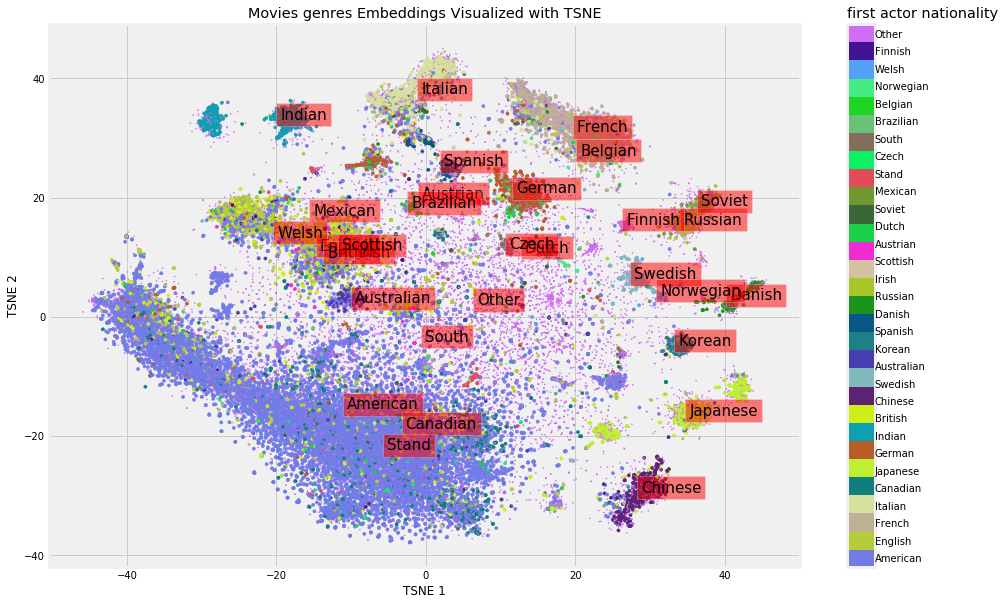

In [106]:
# Plot
plt.figure(figsize = (15, 10))
plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c=movies_natio_df.colors, cmap=cmap, s=movies_natio_df.sizes)
ax = plt.gca()
ax.set_xlabel('TSNE 1');
ax.set_ylabel('TSNE 2');
ax.set_title('Movies genres Embeddings Visualized with TSNE')
# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.set_ticks([])
for j, lab in enumerate(list(index_most_common_nationality.keys())):
    cbar.ax.text(30, 0.3 + j *0.965, lab)
cbar.ax.set_title('first actor nationality', loc = 'left')
for cast, (x, y) in movies_common_natio_sample.items():
    plt.text(s=cast, x=x, y=y, bbox=dict(facecolor='red', alpha=0.5), fontsize=15);

Through supervised training the model has modified its embeddings so that movies with actors with same citizenship have been brought closer to one another. 

Our model seems to have learnt what makes names from countries particular and is able to separate swedish norwegian and danish names, as well as japaneses and chinese. The boundaries between french and belgian actors is blurrer like american and canadians.